In [1]:
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torchaudio as T
import IPython.display as ipd
from IPython.core.display import display
from model import UNet
import imageio

from inference import SDESampling, SDESampling2, ODESampling, ScipySolver, DDIMSampling, ForwardODESampling, \
        ForwardDDIMSampling, SDEInpainting, RegenerateSDESampling2, RandomDDIMSampling
from sde import SDE, VpSdeSigmoid, VpSdeCos, SubVpSdeCos, GeneralizedSubVpSdeCos

T.set_audio_backend('sox')
device=torch.device('cuda:0')
#model_dir = os.getcwd() + '/saved_weights/weights_vp_sigmoid.pt'
model_dir = os.getcwd() + '/saved_weights/weights_vp.pt'
#model_dir = '/home/simon/workspace/diffwave/cascaded_nsynth/weights_ds_4_long_normalised/weights_1-409800.pt'

#model_dir = os.getcwd() + '/saved_weights/weights_subvp.pt'

checkpoint = torch.load(model_dir)
model = UNet().to(device)
#model.load_state_dict(checkpoint['model'])
model.load_state_dict(checkpoint['ema_weights'])
model.eval()

def load_to_device(path, size):
    audio, sr = T.load(path)
    audio = audio[:, :size]
    audio = audio.to(device)
    return audio

def plot_and_hear(audio):
    display(ipd.Audio(audio.cpu(), rate=44100))
    plt.plot(audio.cpu().t().numpy())
    


sns.set()


/home/simon/anaconda3/envs/env_pytorch/lib/python3.8/site-packages/torchaudio/backend/utils.py:59: UserWarning: "sox" backend is deprecated and will be removed in 0.9.0. Please use "sox_io" backend.
  warnings.warn(


# SDE Sampling

In [4]:
sde = VpSdeCos()

In [5]:
class SDESamplingCustom:
    """
    DDPM-like discretisation of the SDE as in https://arxiv.org/abs/2107.00630
    This is the most precise discretization
    """

    def __init__(self, model, sde):
        self.model = model
        self.sde = sde

    def create_schedules(self, nb_steps):
        t_schedule = torch.arange(0, nb_steps + 1) / nb_steps
        t_schedule = (self.sde.t_max - self.sde.t_min) * \
            t_schedule + self.sde.t_min
        sigma_schedule = self.sde.sigma(t_schedule)
        m_schedule = self.sde.mean(t_schedule)

        return sigma_schedule, m_schedule

    def predict(
        self,
        audio,
        nb_steps
    ):
        audio_cat = audio.clone()
        
        with torch.no_grad():

            sigma, m = self.create_schedules(nb_steps)

            for n in range(nb_steps - 1, 0, -1):
                # begins at t = 1 (n = nb_steps - 1)
                # stops at t = 2/nb_steps (n=1)

                audio = m[n-1] / m[n] * audio + (m[n] / m[n-1] * (sigma[n-1])**2 / sigma[n] - m[n-1] / m[n] * sigma[n]) * \
                    self.model(audio, sigma[n])

                if n > 0:  # everytime
                    noise = torch.randn_like(audio)
                    audio += sigma[n-1]*(1 - (sigma[n-1]*m[n] /
                                              (sigma[n]*m[n-1]))**2)**0.5 * noise
                audio_cat = torch.cat([audio, audio_cat])

            # The noise level is now sigma(1/nb_steps) = sigma[0]
            # Jump step
            audio = (audio - sigma[0] * self.model(audio,
                                                   sigma[0])) / m[0]
            audio_cat = torch.cat([audio, audio_cat])

        return audio_cat



In [44]:
sde_sampling = SDESampling2(model, sde)

In [60]:
ddim_sampling = DDIMSampling(model, sde)

In [45]:
audio = torch.randn(30, 21000, device=device)

In [62]:
audio_cat= ddim_sampling.predict(audio, 300)
#audio_sde = torch.cat([audio_sde[k] for k in range(10)], axis=0)

In [63]:
audio_cat3 = audio_cat[:, :18000]

In [64]:
audio_f = audio_cat2.flatten()
audio_f3 = audio_cat3.flatten()

In [39]:
audio_clip=audio_cat.clip(min=-1, max=1)

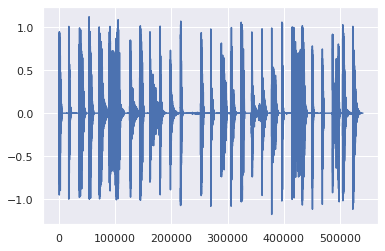

In [65]:
plot_and_hear(audio_f3)

In [41]:
for i in range(100):
    plt.plot(audio_clip[i].cpu().t().numpy())
    plt.savefig(f'img/{100-i}.png')
    plt.close()



    

In [42]:
filenames = []
for i in range(1, 101):
    filenames.append(f'img/{i}.png')

In [43]:
with imageio.get_writer('img/kick.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
for filename in set(filenames):
    os.remove(filename)



# SDE Sampling 2

In [101]:
sde_sampling2 = SDESampling2(model, sde)

In [148]:
audio = torch.randn(1, 21000, device=device)

In [149]:
audio_sde2 = sde_sampling2.predict(audio, 50)
#audio_sde2 = torch.cat([audio_sde2[k] for k in range(10)], axis=0)

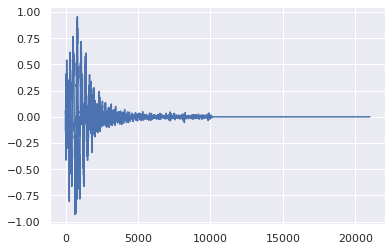

In [150]:
plot_and_hear(audio_sde2)

# ODE Sampling

In [10]:
ode_sampling = ODESampling(model, sde)

In [7]:
audio = torch.randn(10, 21000, device=device)

In [8]:
audio_ode = ode_sampling.predict(audio, 300)
audio_ode = torch.cat([audio_ode[k] for k in range(10)], axis=0)

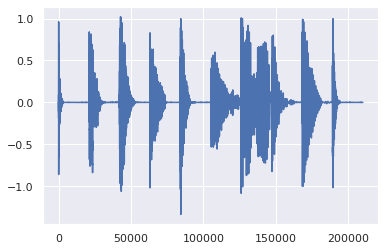

In [9]:
plot_and_hear(audio_ode)

# DDIM Solver

In [15]:
ddim_sampling = DDIMSampling(model, sde)

In [20]:
audio_ddim = ddim_sampling.predict(audio, 20)
audio_ddim = torch.cat([audio_ddim[k] for k in range(10)], axis=0)

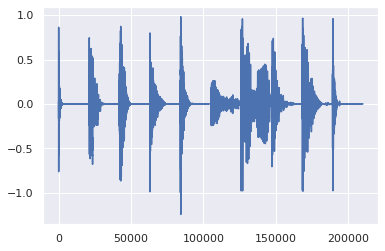

In [21]:
plot_and_hear(audio_ddim)

# Forward + Backward ODE Sampling

In [5]:
Fode = ForwardODESampling(model, sde)
ode_sampling = ODESampling(model, sde)

In [2]:
filenames = glob('/home/simon/workspace/datasets/drums_preprocessed/test/**/*.wav', recursive=True)


In [6]:
n = random.randint(0, len(filenames))
print(filenames[n])
drum = load_to_device(filenames[n], 21000)

/home/simon/workspace/datasets/drums_preprocessed/test/hats/subdir1213/121228-ZTTS_CHat_16.wav


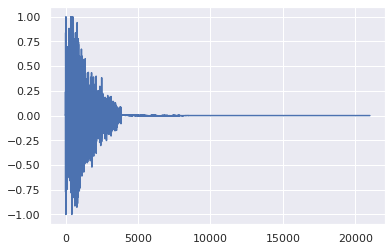

In [7]:
plot_and_hear(drum)

In [8]:
latent = Fode.predict(drum, 300)

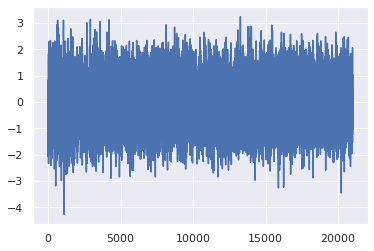

In [49]:
plot_and_hear(latent)

Now, let's compute the reconstruction with the ODE Sampling

In [147]:
reconstruction = ode_sampling.predict(latent, 300)


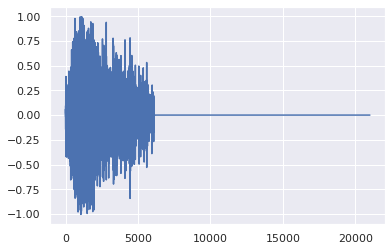

In [148]:
plot_and_hear(reconstruction)

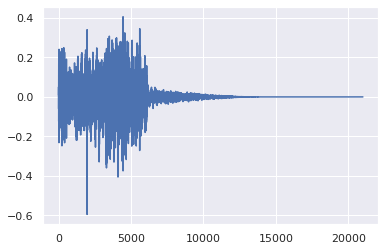

In [149]:
plot_and_hear(drum2-reconstruction)

# Forward + Backward DDIM Sampling

In [10]:
Fddim = ForwardDDIMSampling(model, sde)
ddim_sampling = DDIMSampling(model, sde)

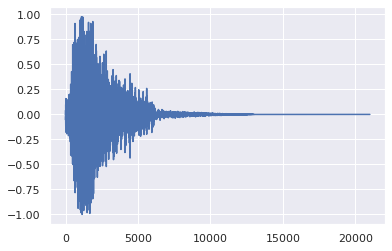

In [134]:
plot_and_hear(drum2)

In [12]:
latent_ddim = Fddim.predict(drum, 300)

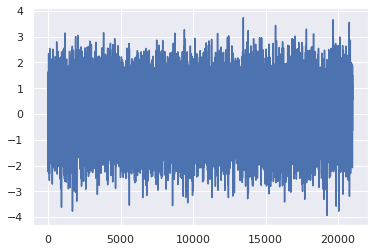

In [140]:
plot_and_hear(latent_ddim)

In [141]:
reconstructed_ddim = ddim_sampling.predict(latent_ddim, 300)

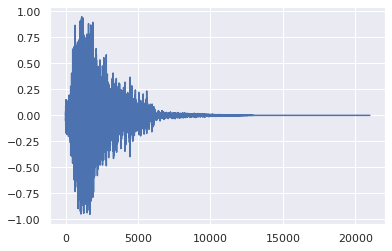

In [142]:
plot_and_hear(reconstructed_ddim)

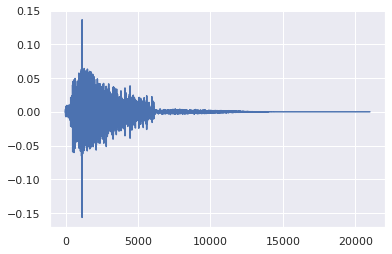

In [144]:
plot_and_hear(reconstructed_ddim-drum2)

# DDIM Interpolation

In [68]:
Fddim = ForwardDDIMSampling(model, sde)
ddim_sampling = DDIMSampling(model, sde)

In [91]:
filenames = glob('/home/simon/workspace/datasets/drums_preprocessed/test/**/*.wav', recursive=True)
n = random.randint(0, len(filenames))
m = random.randint(0, len(filenames))
print(filenames[n], filenames[m])
drum1 = load_to_device(filenames[n], 21000)
drum2 = load_to_device(filenames[m], 21000)

/home/simon/workspace/datasets/drums_preprocessed/test/snares/subdir864/086353-RollSnare_TL.wav /home/simon/workspace/datasets/drums_preprocessed/test/snares/subdir917/091601-dt02_snare-prcm_dnbghost_t3.wav


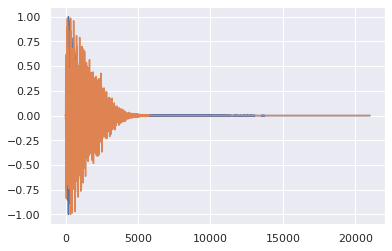

In [92]:
plot_and_hear(drum1)
plot_and_hear(drum2)

In [96]:
latent1 = Fddim.predict(drum1, 100)
latent2 = Fddim.predict(drum2, 100)

In [70]:
def create_latent_mix(lamb, latent1, latent2):
    lamb = np.cos(np.pi*lamb/2)
    return lamb * latent1 + (1-lamb**2)**0.5 * latent2


In [97]:
mix_drum = torch.cat([ddim_sampling.predict(create_latent_mix(k*0.1, latent1, latent2), 100) for k in range(11)], axis=1)

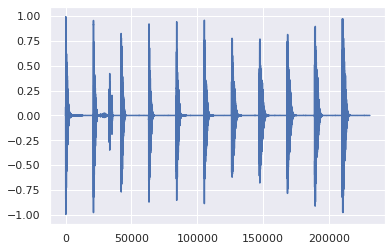

In [95]:
plot_and_hear(mix_drum)


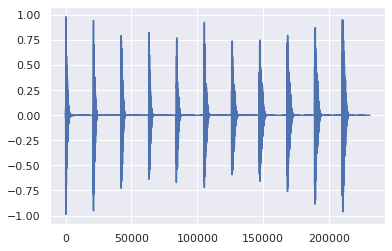

In [98]:
plot_and_hear(mix_drum)


# ODE Interpolation

In [121]:
Fode = ForwardODESampling(model, sde)
ode_sampling = ODESampling(model, sde)

In [123]:
latent1_ode = Fode.predict(drum1, 300)
latent2_ode = Fode.predict(drum2, 300)

In [128]:
mix_drum_ode = torch.cat([ode_sampling.predict(create_latent_mix(k*0.1, latent1_ode, latent2_ode), 300) for k in range(10)], axis=1)

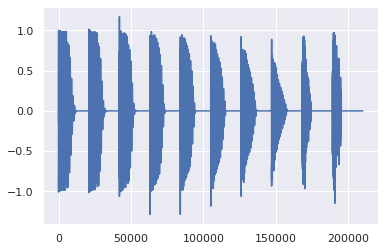

In [129]:
plot_and_hear(mix_drum_ode)


# Regenarate a sound with DDIM

In [28]:
class RandomDDIMSampling2:
    def __init__(self, model, sde):
        self.model = model
        self.sde = sde

    def create_schedules(self, nb_steps):
        t_schedule = torch.arange(0, nb_steps + 1) / nb_steps
        t_schedule = (self.sde.t_max - self.sde.t_min) * \
            t_schedule + self.sde.t_min
        sigma_schedule = self.sde.sigma(t_schedule)
        m_schedule = self.sde.mean(t_schedule)

        return sigma_schedule, m_schedule

    def predict(
        self,
        audio,
        eta,
        nb_steps
    ):

        with torch.no_grad():

            sigma, m = self.create_schedules(nb_steps)

            for n in range(nb_steps - 1, 0, -1):
                # begins at t = 1 (n = nb_steps - 1)
                # stops at t = 2/nb_steps (n=1)

                coef2 = ((1 - eta**2) * sigma[n-1]**2 + eta**2 *
                         sigma[n-1]**4 * (m[n]/(m[n-1]*sigma[n])
                                          )**2)**0.5 - m[n-1]*sigma[n]/m[n]
                coef3 = eta * sigma[n-1] * \
                    (1 - (sigma[n-1]*m[n]/(m[n-1]*sigma[n]))**2)**0.5

                audio = m[n-1] / m[n] * audio + \
                    coef2 * self.model(audio, sigma[n])
                if n > 0:  # everytime
                    noise = torch.randn_like(audio)
                    audio += coef3 * noise

            # The noise level is now sigma(1/nb_steps) = sigma[0]
            # Jump step
            audio = (audio - sigma[0] * self.model(audio,
                                                   sigma[0])) / m[0]


        return audio


In [29]:
Fddim = ForwardDDIMSampling(model, sde)
Rddim = RandomDDIMSampling2(model, sde)


In [83]:
filenames = glob('/home/simon/workspace/datasets/drums_preprocessed/test/**/*.wav', recursive=True)


In [132]:
n = random.randint(0, len(filenames))
print(filenames[n])
drum = load_to_device(filenames[n], 21000)

/home/simon/workspace/datasets/drums_preprocessed/test/snares/subdir886/088546-UBHE_Snare_16.wav


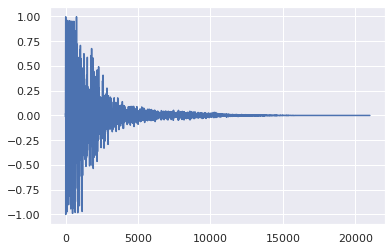

In [133]:
plot_and_hear(drum)

In [134]:
latent = Fddim.predict(drum, 300)

In [139]:
drum_regen = torch.cat([Rddim.predict(latent, 0.5, 100) for _ in range(4)])

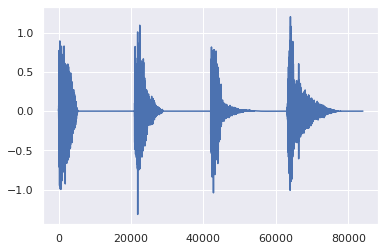

In [140]:
plot_and_hear(drum_regen.flatten())

# Regenerate the sound

In [58]:
#filenames = glob('/home/simon/workspace/datasets/drums_preprocessed/test/**/*.wav', recursive=True)
filenames = glob('/home/simon/workspace/datasets/vocals_dataset/**/*.wav', recursive=True)


In [77]:
regen = RegenerateSDESampling2(model, sde)

In [87]:
n = random.randint(0, len(filenames))
print(filenames[n])
drum = load_to_device(filenames[n], 90000)
drum = drum / max(drum.max(), -drum.min())
drum = drum[:, 18900:]

/home/simon/workspace/datasets/vocals_dataset/FULL/female4/arpeggios/fast_forte/f4_arpeggios_c_fast_forte_e.wav


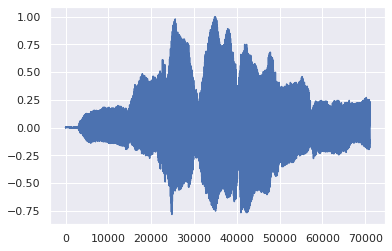

In [88]:
plot_and_hear(drum)

In [95]:
drum_regen = regen.predict(drum, 0.5, 30)

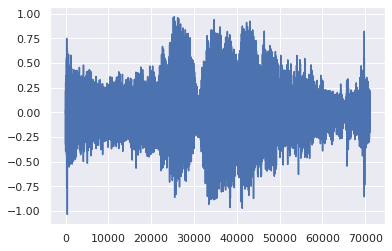

In [96]:
plot_and_hear(drum_regen)

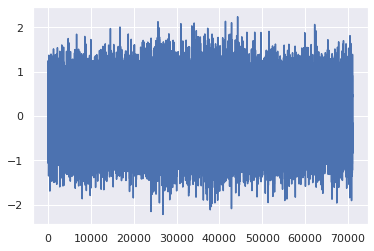

In [98]:
plot_and_hear(drum * (1-0.5**2)**0.5 +  0.5* torch.randn_like(drum))

In [3]:
x=torch.randn(5, 12000, device=device)

In [7]:
with torch.no_grad():
    print(model(x, 0.3))

tensor([[-0.9602,  0.3705, -0.4331,  ...,  0.0039, -0.1999,  0.1904],
        [ 1.9255,  0.9044,  2.2100,  ...,  0.1288,  0.2582,  0.0930],
        [-0.4144,  0.4279, -0.4678,  ..., -0.7233, -0.1859,  0.4415],
        [-2.0826,  0.8049,  0.2593,  ..., -0.3298,  0.2079,  0.1345],
        [ 0.4361, -2.7439,  0.8448,  ..., -0.2418,  0.2774, -0.2409]],
       device='cuda:0')


In [5]:
t = torch.tensor([[0.3], [0.3], [0.3], [0.3], [0.3]], device=device)

In [8]:
with torch.no_grad():
    print(model(x, t))

tensor([[-0.9602,  0.3705, -0.4331,  ...,  0.0039, -0.1999,  0.1904],
        [ 1.9255,  0.9044,  2.2100,  ...,  0.1288,  0.2582,  0.0930],
        [-0.4144,  0.4279, -0.4678,  ..., -0.7233, -0.1859,  0.4415],
        [-2.0826,  0.8049,  0.2593,  ..., -0.3298,  0.2079,  0.1345],
        [ 0.4361, -2.7439,  0.8448,  ..., -0.2418,  0.2774, -0.2409]],
       device='cuda:0')


In [20]:
sigma=np.arange(10)

In [21]:
sigma[3]**2

9